In [39]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth
import numpy as np
from qiskit_experiments.library import StateTomography
from noisy_quantum_teleportation_benchmarking.experiment import Experiment
from noisy_quantum_teleportation_benchmarking.sampler import BaseInputSampler
from noisy_quantum_teleportation_benchmarking.channels import AmplitudeDampingChannel
from noisy_quantum_teleportation_benchmarking.distances import fidelity
from qiskit.compiler import transpile
from qiskit.quantum_info import DensityMatrix

In [29]:
adc = AmplitudeDampingChannel()
backend = AerSimulator()

In [32]:
class EmptySampler(BaseInputSampler):
    def __init__(self) -> None:
        super().__init__(1)

    def get_samples(self):
        return np.array([[0.0, 0.0, 0.0]])

In [40]:
experiment = Experiment(
    [(adc, adc)],
    [(0, 0)],
    EmptySampler(),
    lambda qc: transpile(
        qc,
        backend,
        optimization_level=3,
    ),
)
pub = next(experiment.pubs)
bound_qc = pub[0].assign_parameters([0,0,0,0,0,0,0,0,0,0,0]) 

# QST Experiment
qstexp1 = StateTomography(bound_qc, measurement_indices=[2], target=DensityMatrix.from_label("0"))
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 9.99244498e-01+0.00000000e+00j,
                -1.26761298e-02-2.43771728e-02j],
               [-1.26761298e-02+2.43771728e-02j,
                 7.55501603e-04+5.42101086e-20j]],
              dims=(2,))
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
- verified: False
AnalysisResult
- name: state_fidelity
- value: 0.9992444983971351
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
- verified: False
AnalysisResult
- name: positive
- value: True
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
- verified: False


In [41]:
state_result = qstdata1.analysis_results("state")
print(state_result.value)

DensityMatrix([[ 9.99244498e-01+0.00000000e+00j,
                -1.26761298e-02-2.43771728e-02j],
               [-1.26761298e-02+2.43771728e-02j,
                 7.55501603e-04+5.42101086e-20j]],
              dims=(2,))


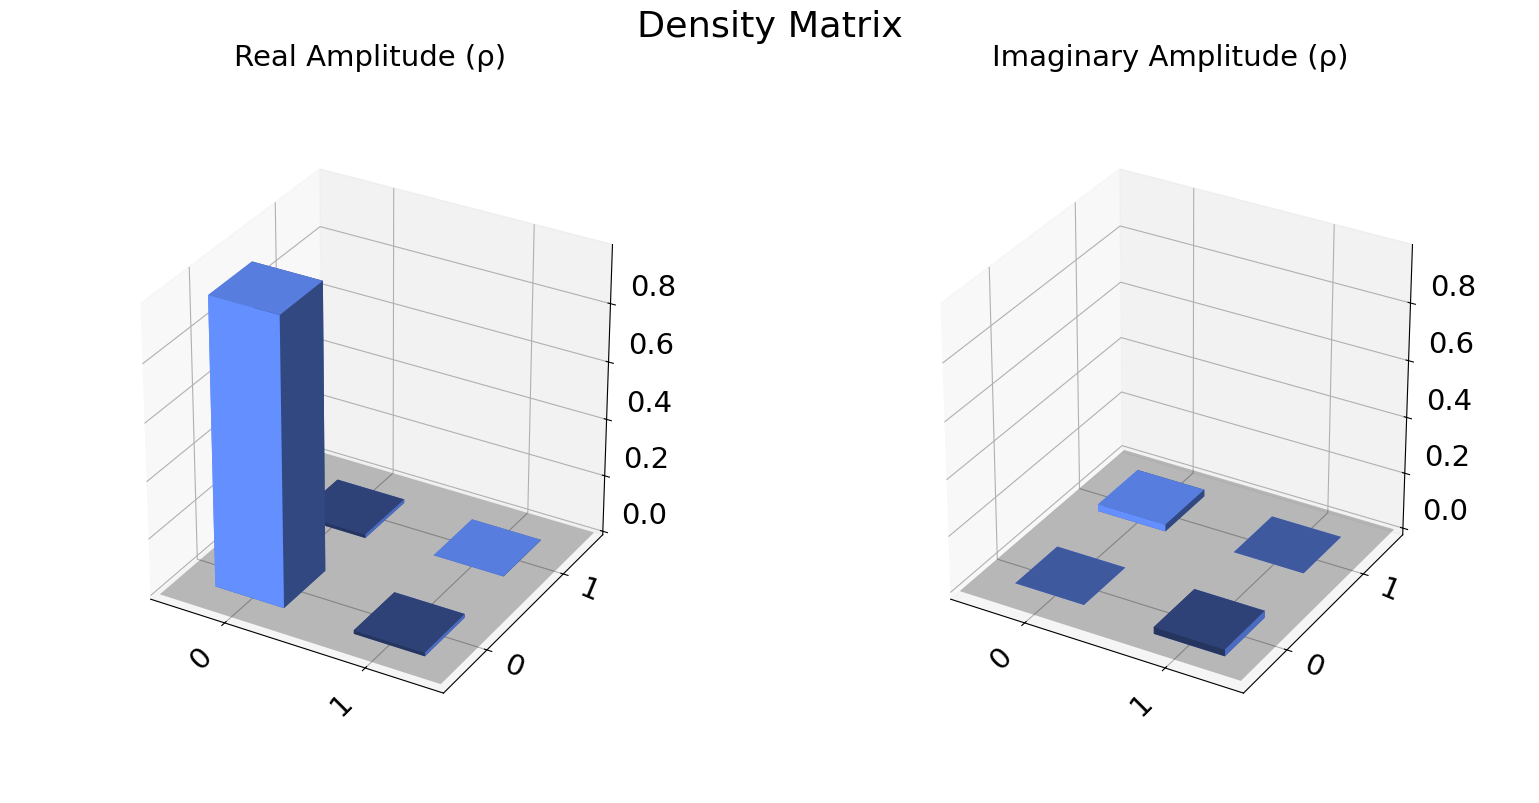

In [42]:
from qiskit.visualization import plot_state_city
plot_state_city(qstdata1.analysis_results("state").value, title='Density Matrix')

In [43]:
fid_result = qstdata1.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result.value))

State Fidelity = 0.99924
